In [1]:
def elong_calc(DIblock):
    #convert to cartesian
    DI_cart = pmag.dir2cart(DIblock)
    #create T matrix
    #Could use the function from pmag: pmag.Tmatrix(Umk_cart_cart),...
    #...however I don't know what the input should be, so did manually...
    #...according to Tanaka (1999)
    T_matrix = [[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
    T_matrix[0][0] = np.sum((DI_cart[:,0]**2))
    T_matrix[0][1] = np.sum((DI_cart[:,0]*DI_cart[:,1]))
    T_matrix[1][0] = np.sum((DI_cart[:,0]*DI_cart[:,1]))
    T_matrix[1][1] = np.sum((DI_cart[:,1]**2))
    T_matrix[0][2] = np.sum((DI_cart[:,0]*DI_cart[:,2]))
    T_matrix[2][0] = np.sum((DI_cart[:,0]*DI_cart[:,2]))
    T_matrix[1][2] = np.sum((DI_cart[:,1]*DI_cart[:,2]))
    T_matrix[2][1] = np.sum((DI_cart[:,1]*DI_cart[:,2]))
    T_matrix[2][2] = np.sum((DI_cart[:,2]**2))
    #calculate eigenvalues and eigenvectors for the T matrix
    eigvalues = pmag.tauV(T_matrix)
    t1 = eigvalues[0][0]
    t2 = eigvalues[0][1]
    t3 = eigvalues[0][2]
    elong = t2/t3
    return elong

In [2]:
import sys
#change to match where the PmagPy folder is on your computer
sys.path.insert(0, '/Users/Laurentia/PmagPy')
import pmag,pmagplotlib,ipmag # import PmagPy functions

import pmag
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def tk03(n=100,dec=0,lat=0,rev='no',G2=0,G3=0):
    """
    generates set of vectors drawn from the TK03.gad model of 
    secular variation (Tauxe and Kent, 2004) at given latitude and rotated 
    about a vertical axis by the given declination 

    Arguments
    ----------
    n number of vectors to determine (default is 100)
    dec mean declination of data set (default is 0)
    lat latitude at which secular variation is simulated (default is 0)
    rev if reversals are to be included this should be 'yes' (default is 'no')
    G2 specify average g_2^0 fraction (default is 0)
    G3 specify average g_3^0 fraction (default is 0)
    """
    tk_03_output=[]
    for k in range(n): 
        gh=pmag.mktk03(8,k,G2,G3) # terms and random seed
        long=random.randint(0,360) # get a random longitude, between 0 and 359
        vec= pmag.getvec(gh,lat,long)  # send field model and lat to getvec
        vec[0]+=dec
        if vec[0]>=360.:
            vec[0]-=360.
        if k%2==0 and rev=='yes':
           vec[0]+=180.
           vec[1]=-vec[1]
        tk_03_output.append([vec[0],vec[1],vec[2]])    
    return tk_03_output

In [4]:
elongation_GAD = []
inclination_GAD = []
for latitude in range(0,90,2):
    data = tk03(200000,dec=0,lat=latitude,G3=0)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_GAD.append(elong) 
    inclination_GAD.append(inc)

In [5]:
print elongation_GAD

[3.5917556021947274, 3.5598855455173211, 3.47796584202819, 3.312227852345262, 3.125852220464985, 2.9487105354741199, 2.7514627660287698, 2.5408549442858717, 2.3672996389398535, 2.2188212241926601, 2.074524645246405, 1.9399456056813706, 1.8242591721439521, 1.7360133435228886, 1.6549501230077459, 1.5676452232744911, 1.5199035917414927, 1.4633277971703103, 1.4023097623033105, 1.3564761909936012, 1.329623485171513, 1.2921875113736876, 1.2576961287246464, 1.232492673540621, 1.1988494859159593, 1.1826423939617021, 1.1520065380722191, 1.1426256175831768, 1.112452028599948, 1.1040544891937494, 1.0994918967960103, 1.0860387905013074, 1.0666084524234871, 1.0490962955826275, 1.0475399589674683, 1.0399808976935767, 1.0291679570631098, 1.0296165771965804, 1.0161871797138653, 1.0201302544011899, 1.0111447550285042, 1.0108342665506831, 1.0018360717501424, 1.0117894298465824, 1.0045891967328076]


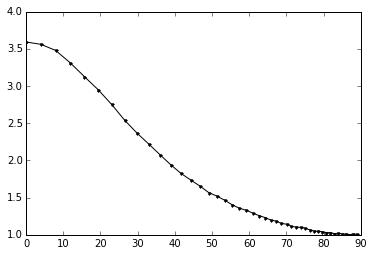

In [6]:
plt.plot(inclination_GAD,elongation_GAD,'k.-')

In [9]:
elongation_G3_20 = []
inclination_G3_20 = []
for latitude in range(0,90,2):
    data = tk03(200000,dec=0,lat=latitude,G3=20)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_G3_20.append(elong) 
    inclination_G3_20.append(inc)

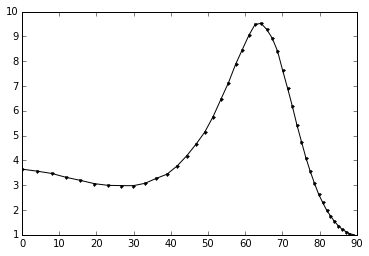

In [10]:
plt.plot(inclination_G3_20,elongation_G3_20,'k.-')

In [15]:
elongation_G2_10 = []
inclination_G2_10 = []
for latitude in range(0,90,2):
    data = tk03(2000,dec=0,lat=latitude,G2=10)
    elong = elong_calc(data)
    rad=np.pi/180.
    inc=np.arctan(2*np.tan(latitude*rad))/rad
    elongation_G2_10.append(elong) 
    inclination_G2_10.append(inc)

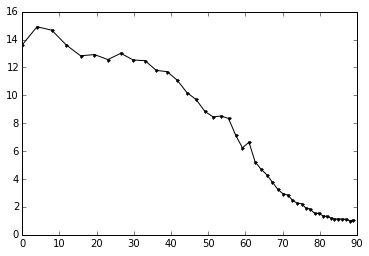

In [16]:
plt.plot(inclination_G2_10,elongation_G2_10,'k.-')